# Kmeans聚类
对于指定的k个簇，簇内样本越相似，聚类效果越好

最佳k值的确定：

    簇内离差平方和拐点法
    轮廓系数法
    间隔统计量法
    主成分分析pca（根据pca绘制散点图，通过肉眼发现数据点的分布块）
    
注意两点：
1. 聚类前必须指定具体的簇数k值，如果未知k,根据前面介绍的三种方法确定合理的k，再调用Kmeans类
2. 如果量纲存在差异，要对原始数据集做标准化处理

两种标准化函数：

    scale=(x-mean(x))/std(x)             -- 均值为0，方差为1
    minmax_scale = (x-min(x))/(max(x)-min(x))  -- [0,1]之间
    
缺点：
1. 该算法对异常点非常敏感，因为中心是通过样本均值确定的 
2. 该算法不适合非球形的簇，因为它是根据距离的方式判断样本之间的相似度

## 拐点法
随着簇数量的增加，簇中的样本量会越来越少，进而导致目标函数的值越来越小。通过可视化方法，重点关注斜率的变化，当斜率由大突然变小时，并且之后的斜率变化缓慢，则认为突然变化的点就是寻找的目标点。因为继续随着簇数k的增加，聚类效果不再有大的变化。

为了验证这个方法的直观性，随机生成三组二元正太分布数据。

In [1]:
# 导入第三方包
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%config ZMQInteractiveShell.ast_node_interactivity='all'   # nootbook使用

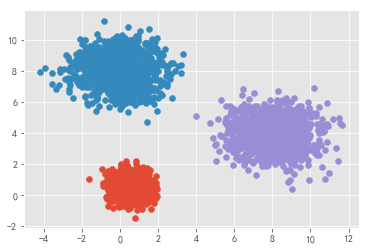

In [108]:
# 随机生成三组二元正态分布随机数 
np.random.seed(1234)
mean1 = [0.5, 0.5]  # 均值
cov1 = [[0.3, 0], [0, 0.3]]  # 协方差矩阵
x1, y1 = np.random.multivariate_normal(mean1, cov1, 1000).T  # [1000,2] 转置成[2,1000], x1是第一行，y1是第二行

mean2 = [0, 8]
cov2 = [[1.5, 0], [0, 1]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, 1000).T

mean3 = [8, 4]
cov3 = [[1.5, 0], [0, 1]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, 1000).T

# 绘制三组数据的散点图
plt.scatter(x1,y1)
plt.scatter(x2,y2)
plt.scatter(x3,y3)
# 显示图形
plt.show()

虚拟的数据呈现3个簇，接下来基于这个虚拟数据，使用拐点法，绘制簇的个数与总的簇内离差平方和之间的折线图，确定该聚为几类比较合适。

数据集前5行
           0         1
0  0.758216 -0.152324
1  1.284726  0.328754
2  0.105317  0.985919
3  0.970816  0.151362
4  0.508597 -0.728369

当簇数k=3时:
簇标签labels: [2 2 2 ... 0 0 0]
簇标签set(labels): {0, 1, 2}
簇中心 [[ 8.04952267  4.00209183]
 [-0.02817479  8.04918385]
 [ 0.51549635  0.51599904]]


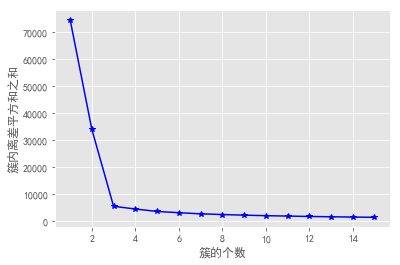

In [112]:
# 构造自定义函数，用于绘制不同k值和对应总的簇内离差平方和的折线图
def k_SSE(X, clusters):
    # 选择连续的K种不同的值
    K = range(1,clusters+1)
    # 构建空列表用于存储总的簇内离差平方和
    TSSE = []
    for k in K:
        # 用于存储各个簇内离差平方和
        SSE = []
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_
        
        if k == 3:
            print('\n当簇数k=3时:')
            print('簇标签labels:',labels)
            print('簇标签set(labels):',set(labels))
            print('簇中心',centers)
            
        # 计算各簇样本的离差平方和，并保存到列表中
        for label in set(labels):
            SSE.append(np.sum((X.loc[labels == label,]-centers[label,:])**2))
        # 计算总的簇内离差平方和 
        TSSE.append(np.sum(SSE))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['SimHei']     # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False       # 用来正常显示负号
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与GSSE的关系
    plt.plot(K, TSSE, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('簇内离差平方和之和')
    # 显示图形
    plt.show()

# 将三组数据集汇总到数据框中
X = pd.DataFrame(np.concatenate([np.array([x1,y1]),np.array([x2,y2]),np.array([x3,y3])], axis = 1).T)
print('数据集前5行\n',X.head())
# 自定义函数的调用
k_SSE(X, 15)

当簇的个数为3时形成了一个明显的拐点，因为k值从1到3，折现斜率较大，k值从3往后斜率突然降低了好多，合理的簇数为3，与3个虚拟数据是吻合的

## 轮廓系数法
该方法综合考虑了簇的密集性与分散性两个信息，如果数据集被分割为理想的k个簇，那么对应的簇内样本会很密集，而簇内样本会很分散。

样本i的轮廓系数的计算公式：
    s(i) = (b(i)-a(i)) / max(a(i),b(i))

    a(i)提现了簇内的密集性，代表样本i与同簇样本点距离的平均值，
    b(i)反应了簇间的分散性，它的计算过程是与其他同簇样本点距离的平均值，然后从平均值中挑选出最小值。
    通过公式可知，s(i)接近于1时，样本分配不合理，s(i)近似为0时，样本i落在了模糊地带，即簇的边界处，s(i)近似为1是，样本分配合理。
    
对应k个簇的总轮廓系数=所有点的轮廓系数求平均值   

缺点：由于要计算所有点的轮廓系数，计算复杂度高，样本量多时，运行时间长

调用函数：from sklearn.metrices import silhouette_score （该函数的聚类簇k必须大于等于2）

下面基于该函数自定义一个函数，绘制不同k值下对应轮廓系数的折现图

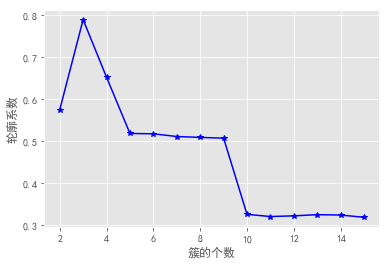

In [114]:
# 构造自定义函数，用于绘制不同k值和对应轮廓系数的折线图
def k_silhouette(X, clusters):
    K = range(2,clusters+1)
    # 构建空列表，用于存储不同簇数下的轮廓系数
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        # 调用字模块metrics中的silhouette_score函数，计算轮廓系数
        S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['SimHei']     # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False       # 用来正常显示负号
    # 设置绘图风格
    plt.style.use('ggplot')    
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    # 显示图形
    plt.show()
    
# 自定义函数的调用
k_silhouette(X, 15)

当k为3时，轮廓系数最大，且比较接近于1，说明簇数为3比较合理，同样与原始数据的3个簇是吻合的。

## 间隔统计量法（暂时没懂）

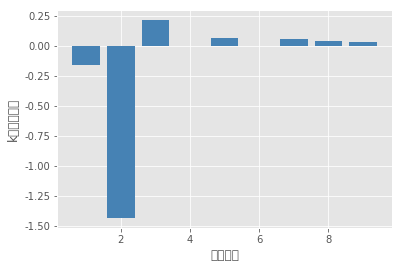

In [115]:
# 自定义函数，计算簇内任意两样本之间的欧氏距离
def short_pair_wise_D(each_cluster):
    mu = each_cluster.mean(axis = 0)
    Dk = sum(sum((each_cluster - mu)**2)) * 2.0 * each_cluster.shape[0]
    return Dk

# 计算簇内的Wk值
def compute_Wk(data, classfication_result):
    Wk = 0
    label_set = set(classfication_result)
    for label in label_set:
        each_cluster = data[classfication_result == label, :]
        Wk = Wk + short_pair_wise_D(each_cluster)/(2.0*each_cluster.shape[0])
    return Wk

# 计算GAP统计量 
def gap_statistic(X, B=10, K=range(1,11), N_init = 10):
    # 将输入数据集转换为数组
    X = np.array(X)
    # 生成B组参照数据
    shape = X.shape
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = np.matrix(np.diag(tops-bots))
    rands = np.random.random_sample(size=(B,shape[0],shape[1]))
    for i in range(B):
        rands[i,:,:] = rands[i,:,:]*dists+bots
    
    # 自定义0元素的数组，用于存储gaps、Wks和Wkbs
    gaps = np.zeros(len(K))
    Wks = np.zeros(len(K))
    Wkbs = np.zeros((len(K),B))
    # 循环不同的k值，
    for idxk, k in enumerate(K):
        k_means =  KMeans(n_clusters=k)
        k_means.fit(X)
        classfication_result = k_means.labels_
        # 将所有簇内的Wk存储起来
        Wks[idxk] = compute_Wk(X,classfication_result)
        
        # 通过循环，计算每一个参照数据集下的各簇Wk值
        for i in range(B):
            Xb = rands[i,:,:]
            k_means.fit(Xb)
            classfication_result_b = k_means.labels_
            Wkbs[idxk,i] = compute_Wk(Xb,classfication_result_b)

    # 计算gaps、sd_ks、sk和gapDiff
    gaps = (np.log(Wkbs)).mean(axis = 1) - np.log(Wks)        
    sd_ks = np.std(np.log(Wkbs), axis=1)
    sk = sd_ks*np.sqrt(1+1.0/B)
    # 用于判别最佳k的标准，当gapDiff首次为正时，对应的k即为目标值
    gapDiff = gaps[:-1] - gaps[1:] + sk[1:]
    
    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['SimHei']     # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False       # 用来正常显示负号
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制gapDiff的条形图
    plt.bar(np.arange(len(gapDiff))+1, gapDiff, color = 'steelblue')
    plt.xlabel('簇的个数')
    plt.ylabel('k的选择标准')
    plt.show()
    
# 自定义函数的调用
gap_statistic(X)    

# Kmeans聚类的应用
注意两点：
1. 聚类前必须指定具体的簇数k值，如果未知k,根据前面介绍的三种方法确定合理的k，再调用Kmeans类
2. 如果量纲存在差异，要对原始数据集做标准化处理

两种标准化函数：

    scale=(x-mean(x))/std(x)             -- 均值为0，方差为1
    minmax_scale = (x-min(x))/(max(x)-min(x))  -- [0,1]之间

## 对iris聚类（已知簇类的情况）

In [116]:
# 读取iris数据集
iris = pd.read_csv(r'iris.csv')
# 查看数据集的前几行
iris.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


前四个变量都是宽度或长度，他们之间没有量纲的差异，故无需做标准化处理，最后一个变量为鸢尾花所属的种类，3类

In [117]:
# 提取出用于建模的数据集X
X = iris.drop(labels = 'Species', axis = 1)
# 构建Kmeans模型
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
# 聚类结果标签
X['cluster'] = kmeans.labels_
# 各类频数统计
X.cluster.value_counts()

0    62
1    50
2    38
Name: cluster, dtype: int64

In [118]:
X.head()

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


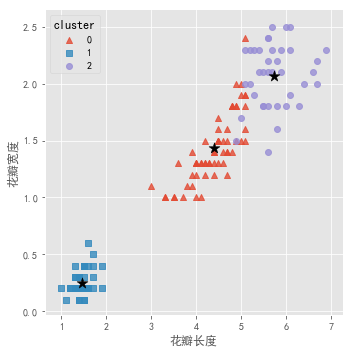

In [127]:
# 导入第三方模块
import seaborn as sns

# 三个簇的簇中心
centers = kmeans.cluster_centers_
# 绘制聚类效果的散点图
sns.lmplot(x = 'Petal_Length',
           y = 'Petal_Width', 
           hue = 'cluster', 
           markers = ['^','s','o'], 
           data = X,
           fit_reg = False,
           scatter_kws = {'alpha':0.8}, 
           legend_out = False)
plt.scatter(centers[:,2], centers[:,3], marker = '*', color = 'black', s = 130)
plt.rcParams['font.sans-serif'] = ['SimHei']     # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False       # 用来正常显示负号
plt.xlabel('花瓣长度')
plt.ylabel('花瓣宽度')
# 图形显示
plt.show()

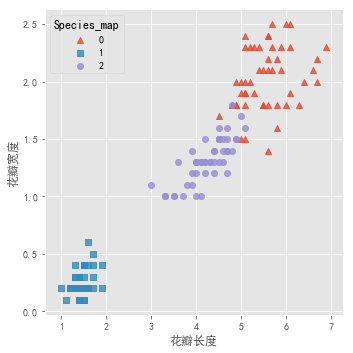

In [128]:
# 增加一个辅助列，将不同的花种映射到0,1,2三种值，目的方便后面图形的对比
iris['Species_map'] = iris.Species.map({'virginica':0,'setosa':1,'versicolor':2})
# 绘制原始数据三个类别的散点图
sns.lmplot(x = 'Petal_Length',
           y = 'Petal_Width',
           hue = 'Species_map',
           data = iris, 
           markers = ['^','s','o'],
           fit_reg = False, 
           scatter_kws = {'alpha':0.8}, 
           legend_out = False)
plt.xlabel('花瓣长度')
plt.ylabel('花瓣宽度')
# 图形显示
plt.show()

聚类效果可以看出，0和2的花种，聚类算法存在一些错误分割，大多数还是比较一致的。
为了对比三个簇内样本之间的差异，使用雷达图对四个维度的信息进行展现。

In [ ]:
# 导入第三方模块
import pygal  # 安装参考：https://blog.csdn.net/lsf_007/article/details/87931823

# 调用Radar这个类，并设置雷达图的填充，及数据范围
radar_chart = pygal.Radar(fill = True)
# 添加雷达图各顶点的名称
radar_chart.x_labels = ['花萼长度','花萼宽度','花瓣长度','花瓣宽度']

# 绘制三个雷达图区域，代表三个簇中心的指标值
radar_chart.add('C1', centers[0])
radar_chart.add('C2', centers[1])
radar_chart.add('C3', centers[2])
# 保存图像
radar_chart.render_to_file('radar_chart.svg')

生成如下图形，C1类型的花，花萼长和花瓣长都是最大的。C2类型的花，对应的3个指标值都比较小，C3类型的花，3个指标的平均值，恰好落在C1和C2之间。

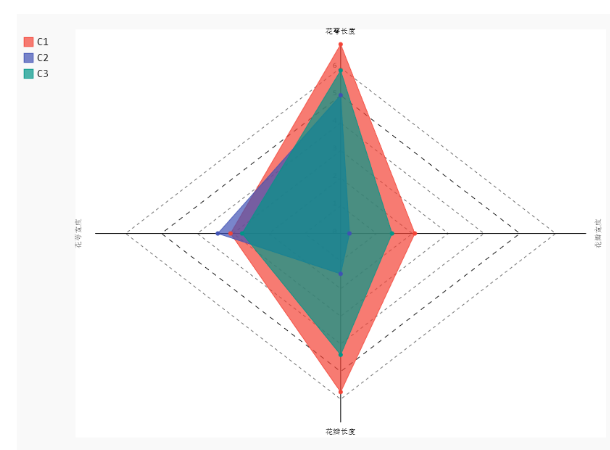

## NBA球员数据集聚类（未知k值）

In [135]:
# 读取球员数据
players = pd.read_csv(r'players.csv')
players.head()
players.info()

,排名,球员,球队,得分,命中-出手,命中率,命中-三分,三分命中率,命中-罚球,罚球命中率,场次,上场时间
0,1,詹姆斯-哈登,火箭,31.9,9.60-21.10,0.454,4.20-10.70,0.397,8.50-9.90,0.861,30,36.1
1,2,扬尼斯-阿德托昆博,雄鹿,29.7,10.90-19.90,0.545,0.50-1.70,0.271,7.50-9.80,0.773,28,38.0
2,3,勒布朗-詹姆斯,骑士,28.2,10.80-18.80,0.572,2.10-5.10,0.411,4.50-5.80,0.775,32,37.3
3,4,斯蒂芬-库里,勇士,26.3,8.30-17.60,0.473,3.60-9.50,0.381,6.00-6.50,0.933,23,32.6
4,4,凯文-杜兰特,勇士,26.3,9.70-19.00,0.510,2.50-6.30,0.396,4.50-5.10,0.879,26,34.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 12 columns):
排名       286 non-null int64
球员       286 non-null object
球队       286 non-null object
得分       286 non-null float64
命中-出手    286 non-null object
命中率      286 non-null float64
命中-三分    286 non-null object
三分命中率    286 non-null float64
命中-罚球    286 non-null object
罚球命中率    286 non-null float64
场次       286 non-null int64
上场时间     286 non-null float64
dtypes: float64(5), int64(2), object(5)
memory usage: 26.9+ KB


得分、命中率，三分命中率，罚球命中率、场次、上场时间都为数值型变量，并且量纲也不一致，故需要对数据集做标准化处理。不妨挑选得分、命中率、三分命中率和罚球命中率4个维度用过球员聚类的依据，首先绘制得分和命中率之间的散点图，便于后面对比聚类后的效果

In [140]:
any(players['球员'].duplicated())

False

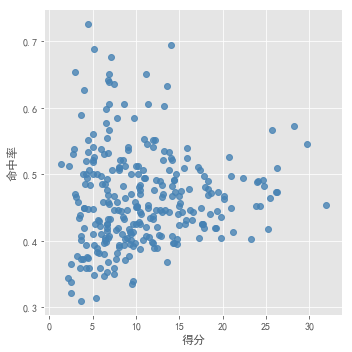

In [136]:
# 绘制得分与命中率的散点图
sns.lmplot(x = '得分', 
           y = '命中率', 
           data = players, 
           fit_reg = False,
           scatter_kws = {'alpha':0.8, 'color': 'steelblue'})
plt.show()

肉眼来看，似乎无法对286名球员进行分割，根据前文介绍的选择k值的方法，对其测试


当簇数k=3时:
簇标签labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 1 1 2 1 1 2 2 2 1 2 2 2 0 2
 0 2 2 1 0 1 1 0 2 2 2 1 2 1 1 1 1 1 1 2 2 0 2 1 1 2 0 2 1 1 1 1 1 0 1 0 1
 1 0 0 2 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0
 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0]
簇标签set(labels): {0, 1, 2}
簇中心 [[0.20642702 0.49494242 0.5980235  0.0947963 ]
 [0.2162977  0.65561579 0.28227357 0.36201935]
 [0.55695612 0.75230092 0.38271104 0.37088312]]


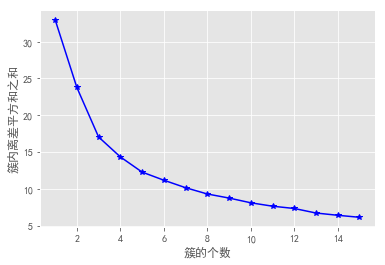

In [141]:
from sklearn import preprocessing
# 数据标准化处理
X = preprocessing.minmax_scale(players[['得分','罚球命中率','命中率','三分命中率']])
# 将数组转换为数据框
X = pd.DataFrame(X, columns=['得分','罚球命中率','命中率','三分命中率'])
# 使用拐点法选择最佳的K值
k_SSE(X, 15)

可选的值可以是3,4,5

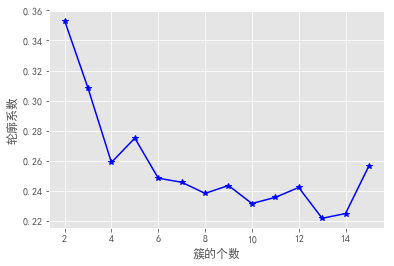

In [142]:
# 使用轮廓系数选择最佳的K值
k_silhouette(X, 15)

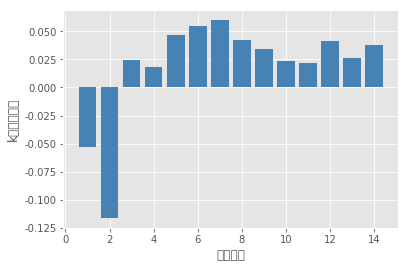

In [143]:
# 使用间隙统计量选择最佳的K值
gap_statistic(X, B = 20, K=range(1, 16))

轮廓系数法，2最大，gap statistic纵坐标首次为正所对应的的k是3，综合考虑，选择3

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0.5, 6.799999999999997, '得分')

Text(6.675000000000004, 0.5, '命中率')

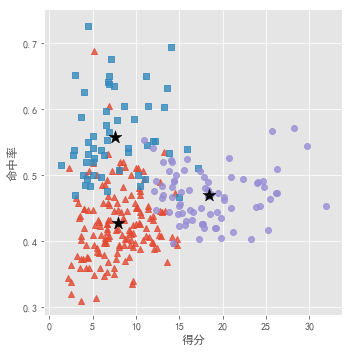

In [148]:
# 将球员数据集聚为3类
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
# 将聚类结果标签插入到数据集players中
players['cluster'] = kmeans.labels_
# 构建空列表，用于存储三个簇的簇中心
centers = []
for i in players.cluster.unique():
    centers.append(
        players.ix[players.cluster == i,['得分','罚球命中率','命中率','三分命中率']].mean()
    )
# 将列表转换为数组，便于后面的索引取数
centers = np.array(centers)

# 绘制散点图
sns.lmplot(x = '得分', 
           y = '命中率', 
           hue = 'cluster',
           data = players, 
           markers = ['^','s','o'],
           fit_reg = False, 
           scatter_kws = {'alpha':0.8}, 
           legend = False)
# 添加簇中心
plt.scatter(centers[:,0], centers[:,2], c='k', marker = '*', s = 180)
plt.rcParams['font.sans-serif'] = ['SimHei']     # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False       # 用来正常显示负号
plt.xlabel('得分')
plt.ylabel('命中率')
# 图形显示
plt.show()

In [155]:
centers  # 实际簇中心

array([[18.42631579,  0.82194737,  0.46968421,  0.37064474],
       [ 7.61666667,  0.63938889,  0.55877778,  0.0947963 ],
       [ 7.94487179,  0.75513462,  0.42746154,  0.36219231]])

    对比三角和正方形，他们的区别提现在命中率上。正方形：低的分高命中率型。三角形：低得分低命中率型。对比三角和圆形，他们的区别体现在得分上，圆形是高得分低命中率型，当然也有几个高得分高命中率的几个球员。
    需要注意：由于对原始数据进行了标准化处理，簇中心不能直接使用cluster_centers获得，因为他们返回的是原始数据标准化后的中心，需要再代码中用过for循环重新找出原始数据下的簇中心，并将其以五角星标记添加到散点图中去。
    最后看三类球员的雷达图，对比四个指标上的差异，由于量纲不一致，需要使用标准化后的数据

In [156]:
centers_std  # 原始数据标准化后的簇中心

array([[0.21715267, 0.65705128, 0.28235947, 0.36219231],
       [0.20642702, 0.49494242, 0.5980235 , 0.0947963 ],
       [0.55968352, 0.75062657, 0.38385628, 0.37064474]])

In [158]:
# 雷达图
# 调用模型计算出来的簇中心
centers_std = kmeans.cluster_centers_
# 设置填充型雷达图
radar_chart = pygal.Radar(fill = True)
# 添加雷达图各顶点的名称
radar_chart.x_labels = ['得分','罚球命中率','命中率','三分命中率']

# 绘制雷达图代表三个簇中心的指标值
radar_chart.add('C1', centers_std[0])
radar_chart.add('C2', centers_std[1])
radar_chart.add('C3', centers_std[2])
# 保存图像
radar_chart.render_to_file('radar_chart.svg')

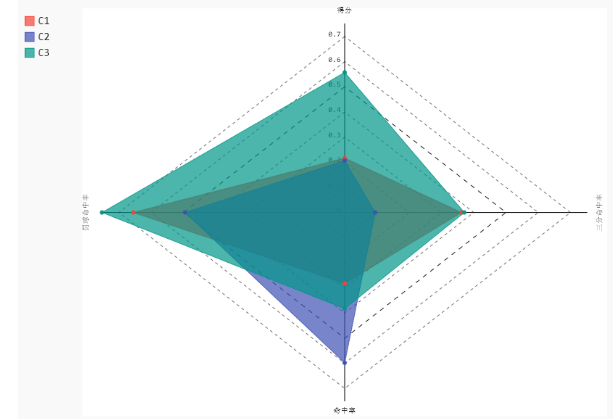